## Queremos saber donde vive alguno de nuestros usuarios, para los usuarios que tiene más de 50 registros a negocios distintos en la tabla reviews obtenga el promedio y desviación estándar de la latitud y longitud de los negocios que calificaron (contando cada negocio una sola vez). Para el usuario que menos desviación estándar sumada tenga de ambas coordenadas muestre ese promedio y dónde está eso (https://www.gps-coordinates.net/) y cómo se llama el usuario para después irlo a buscar a la casa.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt update
!apt install openjdk-8-jdk-headless -qq
#!apt install default-jre
#!apt install default-jdk
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd

In [ ]:
import math 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

In [ ]:
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/Dataset yelp/review.csv', usecols=['review_id',	'user_id',	'business_id'])
#df = df.to_parquet('/content/drive/MyDrive/ODD tp 1 dataset/reviewS35.parquet')

In [ ]:
df = sqlContext.read.parquet('/content/drive/MyDrive/ODD tp 1 dataset/reviewS35.parquet', header=True, inferSchema=True)
rdd_review = df.rdd

In [ ]:
df2 = sqlContext.read.parquet('/content/drive/MyDrive/ODD tp 1 dataset/business.parquet', header=True, inferSchema=True)
rdd_bis = df2.rdd

# Primero elimino tuplas duplicadas para asi obtener los registros a negocios distintos. 

In [ ]:
rdd_review.take(5)

[Row(review_id='KU_O5udG6zpxOg-VcAEodg', user_id='mh_-eMZ6K5RLWhZyISBhwA', business_id='XQfwVwDr-v0ZS3_CbbE5Xw'),
 Row(review_id='Sx8TMOWLNuJBWer-0pcmoA', user_id='bcjbaE6dDog4jkNY91ncLQ', business_id='e4Vwtrqf-wpJfwesgvdgxQ'),
 Row(review_id='lUUhg8ltDsUZ9h0xnwY4Dg', user_id='RreNy--tOmXMl1en0wiBOg', business_id='cPepkJeRMtHapc_b2Oe_dw'),
 Row(review_id='-P5E9BYUaK7s3PwBF5oAyg', user_id='Jha0USGDMefGFRLik_xFQg', business_id='bMratNjTG5ZFEA6hVyr-xQ'),
 Row(review_id='YbMyvlDA2W3Py5lTz8VK-A', user_id='4hBhtCSgoxkrFgHa4YAD-w', business_id='bbEXAEFr4RYHLlZ-HFssTA')]

In [ ]:
rdd_review_sliced = rdd_review.map(lambda x: (x.user_id, x.business_id))

In [ ]:
rdd_review_sliced = rdd_review_sliced.distinct().cache()


# Filtro para conseguir los usuarios que tienen más de 50 registros a negocios distintos en la tabla reviews

In [ ]:
cincuenta_usuarios = rdd_review_sliced.map(lambda x: (x[0], 1)).reduceByKey(lambda a,b: a+b).filter(lambda x: x[1] > 50)

In [ ]:
cincuenta_usuarios.take(10)

[('1pbG4SaIIFJZtkg_IN9Sog', 72),
 ('OVoM0VzWh_Mneq-69_GzeQ', 127),
 ('aP3GeJVUUqhHTPGLj_9lmg', 159),
 ('lSA0wc9EnIndn5F3Q6RNmw', 219),
 ('HWGLG6suCnwpgx5vVudeKA', 80),
 ('OExmdhEdcKHQQqXrv6ftTg', 176),
 ('DoqpE5_OlVNUNm_S25ghDQ', 51),
 ('b8aCjlTJDA0hoZLMAE-iLg', 102),
 ('AnmnLjGURagnzk9PukE-ZQ', 110),
 ('d5bqRsw4CGukrT_lLYtGDA', 68)]

# Joineo los business_id y así logro un rdd con los business_id como key con los usuarios que tienen más de 50 reviews. 

In [ ]:
joineado = cincuenta_usuarios.join(rdd_review_sliced)

In [ ]:
joineado_simple = joineado.map(lambda x: (x[1][1], x[0])) # dejo como key los business_id y como value los user_id para hacer join con la otra tabla

In [ ]:
joineado_simple.take(10)

[('qjqrPWknVLOiPSuahsJoig', 'aP3GeJVUUqhHTPGLj_9lmg'),
 ('VeJqScDLsoA5WasQSv_Jfw', 'aP3GeJVUUqhHTPGLj_9lmg'),
 ('emrUsUZvqCkytUu4i3kjLw', 'aP3GeJVUUqhHTPGLj_9lmg'),
 ('uUShztrFYFUivAfOePt8-w', 'aP3GeJVUUqhHTPGLj_9lmg'),
 ('Di7oUYlb1MiDi9UmEZgpOQ', 'aP3GeJVUUqhHTPGLj_9lmg'),
 ('CAjQfRFBcMp3XycC1mWYxg', 'aP3GeJVUUqhHTPGLj_9lmg'),
 ('2MUvyUxQ8KDo5_H_re3OKA', 'aP3GeJVUUqhHTPGLj_9lmg'),
 ('18P_M2ImCiSPQY_9eVrYJg', 'aP3GeJVUUqhHTPGLj_9lmg'),
 ('ZJKGcR7J0n1DGbLqt1N5Vw', 'aP3GeJVUUqhHTPGLj_9lmg'),
 ('Ih-mZYBB_8fzsj6QqvArTw', 'aP3GeJVUUqhHTPGLj_9lmg')]

# Joineo con la otra tabla (business.csv) para conseguir las coordenadas de cada negocio. 

In [ ]:
bis_sliced = rdd_bis.map(lambda x: (x.business_id, (x.latitude, x.longitude)))

In [ ]:
bis_sliced.take(5)

[('Pns2l4eNsfO8kk83dixA6A', (34.4266787, -119.7111968)),
 ('mpf3x-BjTdTEA3yCZrAYPw', (38.551126, -90.335695)),
 ('tUFrWirKiKi_TAnsVWINQQ', (32.223236, -110.880452)),
 ('MTSW4McQd7CbVtyjqoe9mw', (39.9555052, -75.1555641)),
 ('mWMc6_wTdE0EUBKIGXDVfA', (40.3381827, -75.4716585))]

In [ ]:
join_final = joineado_simple.join(bis_sliced)

In [ ]:
join_final.take(5)

[('uUShztrFYFUivAfOePt8-w',
  ('aP3GeJVUUqhHTPGLj_9lmg', (39.9688147758, -86.1309269944))),
 ('uUShztrFYFUivAfOePt8-w',
  ('ZQQ-UkzlN8SoMwtSBUlXBA', (39.9688147758, -86.1309269944))),
 ('uUShztrFYFUivAfOePt8-w',
  ('Byog9k35hMURW_O1dIteHw', (39.9688147758, -86.1309269944))),
 ('uUShztrFYFUivAfOePt8-w',
  ('b4BAxGBvJX4COgvEcZRZtg', (39.9688147758, -86.1309269944))),
 ('uUShztrFYFUivAfOePt8-w',
  ('m982bOXdBgpmVU3ROb1B2Q', (39.9688147758, -86.1309269944)))]

# Me quedo con usuarios y coordenadas

In [ ]:
users_direccion = join_final.map(lambda x: (x[1][0], x[1][1])) 

In [ ]:
users_direccion.take(5)

[('aP3GeJVUUqhHTPGLj_9lmg', (39.9688147758, -86.1309269944)),
 ('ZQQ-UkzlN8SoMwtSBUlXBA', (39.9688147758, -86.1309269944)),
 ('Byog9k35hMURW_O1dIteHw', (39.9688147758, -86.1309269944)),
 ('b4BAxGBvJX4COgvEcZRZtg', (39.9688147758, -86.1309269944)),
 ('m982bOXdBgpmVU3ROb1B2Q', (39.9688147758, -86.1309269944))]

# Calculo la latitud y longitud promedio por usuario por separado para después joinearlos.  

In [ ]:
user_latitud_promedio = users_direccion.map(lambda x: (x[0], x[1][0])).mapValues(lambda x: (x, 1))\
           .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))\
           .mapValues(lambda x: x[0]/x[1])

In [ ]:
user_latitud_promedio.take(5)

[('b4BAxGBvJX4COgvEcZRZtg', 39.188751142455935),
 ('WwulXySQN8t2hwqH_yWurA', 39.74452680224804),
 ('DWs3moceKvfeAwcenO_9rg', 39.05516820774509),
 ('_0ZkcuLf7FRHuPLDKZY9OQ', 39.756109557786786),
 ('7x6bZI3PIX4xsVrm3kosVg', 39.41420317680694)]

In [ ]:
user_longitud_promedio = users_direccion.map(lambda x: (x[0], x[1][1])).mapValues(lambda x: (x, 1))\
           .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))\
           .mapValues(lambda x: x[0]/x[1])

In [ ]:
user_longitud_promedio.take(5)

[('b4BAxGBvJX4COgvEcZRZtg', -86.4023727334288),
 ('WwulXySQN8t2hwqH_yWurA', -86.18261188109315),
 ('DWs3moceKvfeAwcenO_9rg', -86.28385471346722),
 ('_0ZkcuLf7FRHuPLDKZY9OQ', -86.13741058326416),
 ('7x6bZI3PIX4xsVrm3kosVg', -86.35770210473055)]

In [ ]:
user_promedio = user_latitud_promedio.join(user_longitud_promedio)

# Calculo la varianza para la latitud y longitud y en el último map aplico la raíz cuadrada para así conseguir la desviación estándar de cada coordenada por usuario

In [ ]:
user_latitud_std = users_direccion.map(lambda x: (x[0], x[1][0])).mapValues(lambda x: (1, x, x*x))\
          .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2]))\
          .mapValues(lambda x: (x[2]/x[0] - (x[1]/x[0])**2)) \
          .map(lambda x: (x[0], math.sqrt(x[1])))

In [ ]:
user_latitud_std.take(5)

[('b4BAxGBvJX4COgvEcZRZtg', 2.4954423561598857),
 ('WwulXySQN8t2hwqH_yWurA', 0.6213614603043002),
 ('DWs3moceKvfeAwcenO_9rg', 1.523226577625432),
 ('_0ZkcuLf7FRHuPLDKZY9OQ', 0.716460019967162),
 ('7x6bZI3PIX4xsVrm3kosVg', 1.9820971121078452)]

In [ ]:
user_longitud_std = users_direccion.map(lambda x: (x[0], x[1][1])).mapValues(lambda x: (1, x, x*x))\
          .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2]))\
          .mapValues(lambda x: (x[2]/x[0] - (x[1]/x[0])**2)) \
          .map(lambda x: (x[0], math.sqrt(x[1])))

In [ ]:
user_longitud_std.take(5)

[('b4BAxGBvJX4COgvEcZRZtg', 0.9927255208105997),
 ('WwulXySQN8t2hwqH_yWurA', 0.579945596604806),
 ('DWs3moceKvfeAwcenO_9rg', 0.26929608936176747),
 ('_0ZkcuLf7FRHuPLDKZY9OQ', 0.14283305379835487),
 ('7x6bZI3PIX4xsVrm3kosVg', 0.9240091756648432)]

# Joineo y sumo las desviaciones estandar, de la cual saco la que es menor.

In [ ]:
std_menor = user_latitud_std.join(user_longitud_std).flatMap(lambda x: [((x[0]), (x[1][0]+x[1][1]))]).takeOrdered(1, lambda x: x[1])

In [ ]:
std_menor

[('XetBcu9wS-py5BXtJtTc6w', 0.012375032610008586)]

# Filtro el resultado de 'std_menor' en el rdd donde tenia promediadas las coordenadas para así conseguir el nombre y dirección del usuario.

In [ ]:
user_promedio.filter(lambda x: x[0]==std_menor[0][0]).collect()

[('XetBcu9wS-py5BXtJtTc6w', (39.947476974315, -75.16780540930334))]

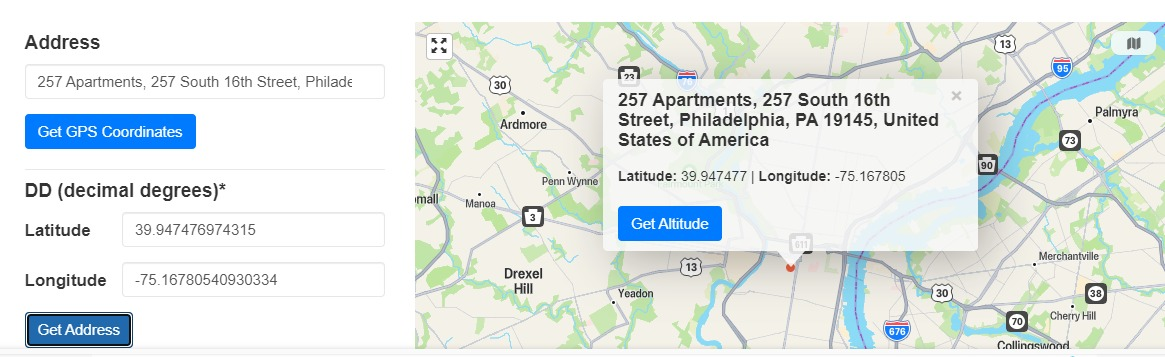